# Inpainting image by k-SVD

Comparison of reconstructed images using dictionary by k-SVD and DCT.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

## Generating input image

* Load input image and mask certain range of it

In [2]:
from skimage import io, data
from typing import Tuple

In [3]:
def make_deficit_image(img: np.ndarray, ratio:float) -> Tuple[np.ndarray, np.ndarray]:
    mask = (np.random.rand(img.shape[0], img.shape[1]) > ratio)
    return img * mask, mask

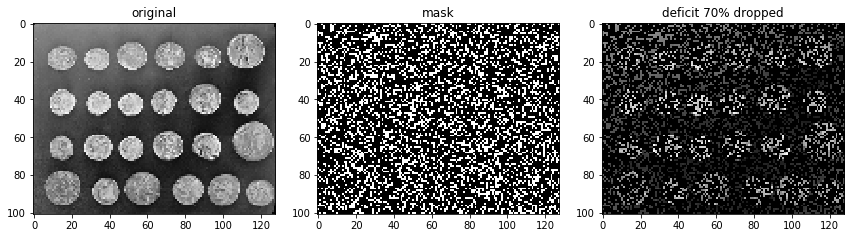

In [118]:
# prepare images for further testing
original_img = data.coins()
original_img = original_img[::3,::3]

drop_ratio = 0.7
deficit_img, mask = make_deficit_image(original_img, drop_ratio)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('original')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.subplot(1, 3, 3)
plt.imshow(deficit_img, cmap='gray')
plt.title('deficit {0:.0f}% dropped'.format(drop_ratio * 100))

plt.tight_layout()

# Inpainting by DCT and k-SVD

In [119]:
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition.dict_learning import sparse_encode

import sys
sys.path.append('..')
from spmimage.decomposition import KSVD
from spmimage.decomposition import sparse_encode_with_mask

In [126]:
# common functions
def extract_and_flatten(img:np.ndarray, patch_size:int) -> np.ndarray:
    patches = extract_patches_2d(img, (patch_size, patch_size))
    X = []
    for p in patches:
        X.append(p.flatten())
    return np.array(X)    

def img_sparse_encode_with_mask(img, H, k0, mask, patch_size):
    Y = extract_and_flatten(img, patch_size)
    M = extract_and_flatten(mask, patch_size)
    W = sparse_encode_with_mask(Y, H, M, algorithm='omp', n_nonzero_coefs=k0)
    return W

def reconstruct_image(img, W, H, patch_size):
    recon_patches = (np.dot(W, H)).reshape((-1, patch_size, patch_size))
    recon_img = reconstruct_from_patches_2d(recon_patches, img.shape)
    return recon_img

In [122]:
# dictionary functions
def get_dct_dict(patch_size: int, dict_size: int):
    A_1D = np.zeros((dict_size, patch_size))
    for k in np.arange(dict_size):
        for i in np.arange(patch_size):
            A_1D[k, i] = np.cos(i * k * np.pi / float(dict_size))
        if k != 0:
            A_1D[k, :] -= A_1D[k, :].mean()            
    return np.kron(A_1D, A_1D)

def get_ksvd_dict(img, n_components, k0, patch_size):
    X = np.array(extract_and_flatten(img, patch_size), dtype='float64')
    model = KSVD(n_components=n_components, transform_n_nonzero_coefs=k0, max_iter=10, missing_value=0, method='normal')
    for i in range(10):
        # sampling
        idx = np.random.permutation(len(X))[:n_components*3]
        model.fit(X[idx])
    return model.components_

## Reconstruction

In [123]:
from skimage.measure import compare_psnr

In [124]:
# constants for reconstruction
patch_size = 8
k0 = 10

# DCT dictionary size
dict_size = 16

# k-SVD component size
n_components = 32

In [127]:
%%time

# DCT
dct_dict = get_dct_dict(patch_size, dict_size)
dct_code = img_sparse_encode_with_mask(deficit_img, dct_dict, k0, mask, patch_size)
dct_reconstruct_img = reconstruct_image(deficit_img, dct_code, dct_dict, patch_size)

/Users/admin/develop/hacarus/spm-image/examples_venv/lib/python3.6/site-packages/sklearn/decomposition/dict_learning.py:160: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


CPU times: user 14.2 s, sys: 1.39 s, total: 15.6 s
Wall time: 14 s


In [128]:
%%time

# k-SVD
ksvd_dict= get_ksvd_dict(deficit_img, n_components, k0, patch_size)
ksvd_code = img_sparse_encode_with_mask(deficit_img, ksvd_dict, k0, mask, patch_size)
ksvd_reconstruct_img = reconstruct_image(deficit_img, ksvd_code, ksvd_dict, patch_size)

/Users/admin/develop/hacarus/spm-image/examples_venv/lib/python3.6/site-packages/sklearn/decomposition/dict_learning.py:160: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


CPU times: user 13.6 s, sys: 192 ms, total: 13.8 s
Wall time: 14.9 s


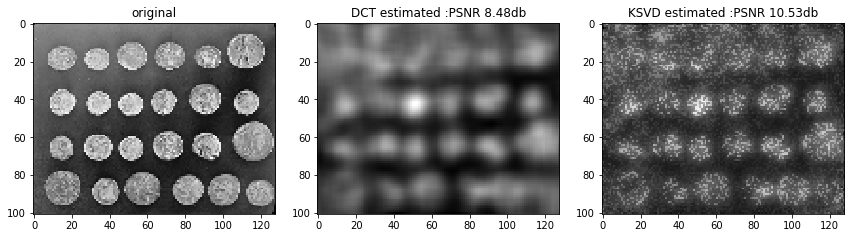

In [129]:
dct_psnr = compare_psnr(original_img, dct_reconstruct_img.astype(np.uint8))
ksvd_psnr = compare_psnr(original_img, ksvd_reconstruct_img.astype(np.uint8))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('original')

plt.subplot(1, 3, 2)
plt.imshow(dct_reconstruct_img, cmap='gray')
plt.title('DCT estimated :PSNR {0:.2f}db'.format(dct_psnr))

plt.subplot(1, 3, 3)
plt.imshow(ksvd_reconstruct_img, cmap='gray')
plt.title('KSVD estimated :PSNR {0:.2f}db'.format(ksvd_psnr))

plt.tight_layout()

### DCT and k-SVD dictionary 

CPU times: user 7.59 s, sys: 94.5 ms, total: 7.68 s
Wall time: 7.74 s


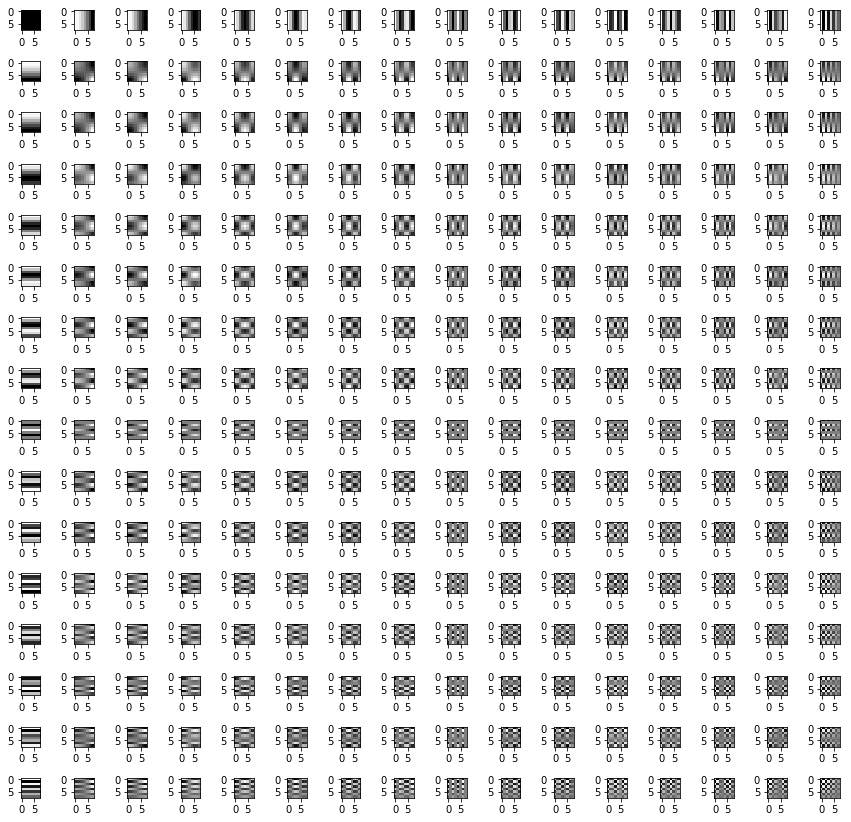

In [130]:
%%time

# DCT dictionary
n_size = dct_dict.shape[0]
n_cols = 16
n_rows = (n_size // n_cols) + 1

plt.figure(figsize=(12, 12))

for i, p in enumerate(dct_dict):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(p.reshape(patch_size, patch_size), cmap='gray')

plt.tight_layout()

CPU times: user 863 ms, sys: 15.1 ms, total: 878 ms
Wall time: 886 ms


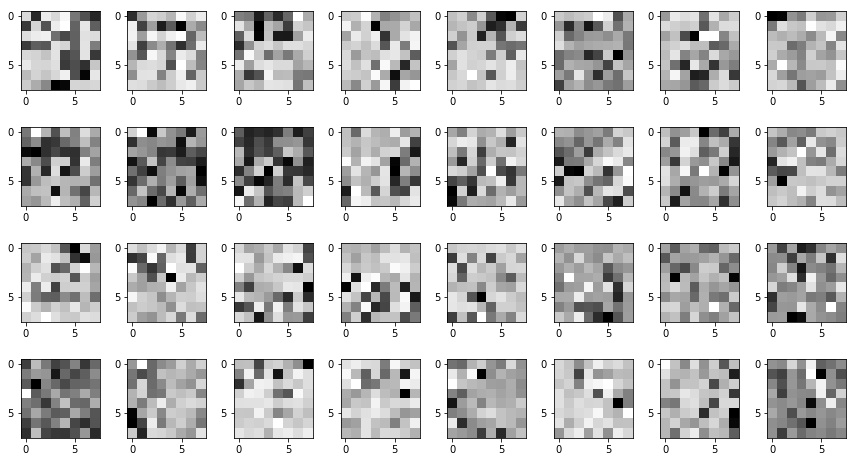

In [131]:
%%time

# KSVD dictionary
n_size = ksvd_dict.shape[0]
n_cols = 8
n_rows = (n_size // n_cols) + 1

plt.figure(figsize=(12, 8))

for i, p in enumerate(ksvd_dict):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(p.reshape(patch_size, patch_size), cmap='gray')

plt.tight_layout()